# Определение стоимости автомобилей

# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных 


Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:
* Price — цена (евро)

# Установка библиотек

In [3]:
!pip install phik -q

# Импорт библиотек и создание констант

In [4]:
import numpy as np
import phik
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from time import time
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


RANDOM_STATE = 42
TEST_SIZE = 0.25

warnings.filterwarnings('ignore')

# Методы для работы

**Метод для построения диаграмм**

In [5]:
def create(data, column, type, bins = 100, color = 'blue', alpha = 0.5, edge_color='black', edge_width=1.2, rotation = 45):
    category_counts = data[column].value_counts()
    if type == "hist":
        """
        Создает гистограмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(12, 6))
        plt.hist(data=data, x=column, bins=bins, color=color, alpha=alpha, edgecolor=edge_color, linewidth=edge_width)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Призак {column} - Частота распределения', fontsize=18)
        plt.grid(True)
        plt.show()
    elif type == "barplot":
        """
        Создает столбчатую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.xticks(rotation=rotation)
        new_data = data[column].value_counts()
        df_new_data = new_data.reset_index()
        df_new_data.columns = [column, 'count']

        sns.barplot(x=column, y='count', data = df_new_data)
        plt.title(f'{column}.Частота распределения')
        plt.xlabel(f'{column}')
        plt.ylabel(f'количество {column}')
    elif type == "pie":
        """
        Создает круговую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Круговая диаграмма для {column}', fontsize=18)
        plt.show()
    elif type == "boxplot":
        """
        Создает ящик с усами для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.boxplot(data[column], notch=True, patch_artist=True, boxprops=dict(facecolor=color, color=edge_color),
                    whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color),
                    medianprops=dict(color=edge_color), flierprops=dict(markeredgecolor=edge_color, markerfacecolor=color))
        plt.ylabel("Значения")
        plt.xlabel(column)
        plt.title(f'Ящик с усами для признака {column}', fontsize=18)
        plt.grid(True)
        plt.show()

**Метод для построения phik матрицы**

In [6]:
def create_phik(data, cols):
    corr_matrix = data.phik_matrix(interval_cols = cols)
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='Greens')
    plt.title('Phik')
    plt.show()

**Метод для разделения признаков**

In [7]:
def cat_num_col(df):
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    return num_col_names, cat_col_names

**Метод для обучения моделей**

In [8]:
def optimize_model_with_grid_search(pipeline, parameter_grid, features, targets):
    search_start_time = time()

    grid_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=parameter_grid,
        n_jobs=-1,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(features, targets)

    search_end_time = time()

    best_parameters = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    best_rmse = np.sqrt(-grid_search.best_score_)

    retrain_start_time = time()
    best_estimator.fit(features, targets)
    retrain_end_time = time()

    prediction_start_time = time()
    best_estimator.predict(features)
    prediction_end_time = time()

    execution_duration = search_end_time - search_start_time
    retrain_duration = retrain_end_time - retrain_start_time
    prediction_duration = prediction_end_time - prediction_start_time

    return best_parameters, execution_duration, best_rmse, best_estimator, prediction_duration, retrain_duration

## Подготовка данных

### Загрузка данных

In [9]:
try:
    df_auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except FileNotFoundError:
    print('Файл не найден')

### Информация о датасете

In [10]:
display(df_auto.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [11]:
display(df_auto.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Предобработка данных

**Удаление неинформативных столбцов**

Некоторые столбцы из датасета не несут информации для определения стоимости автомобиля на основании технических характеристик, удалим их.
Стобцы для удаления:
* DateCrawled
* RegistrationMonth
* DateCreated
* NumberOfPictures
* PostalCode
* LastSeen

In [12]:
columns_to_drop = ['RegistrationMonth', 'DateCreated' , 'NumberOfPictures', 'PostalCode', 'LastSeen']

df_auto = df_auto.drop(columns_to_drop, axis = 1)

print(df_auto.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')


### Изменение названий столбцов

In [13]:
df_auto = df_auto.rename(columns={
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear' : 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'kilometer',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'Repaired' : 'repaired'})

### Обработка пропусков

**Посмотрим на общее количество пропусков по столбцам**

In [14]:
display(df_auto.isna().sum().to_frame(name="empty_value").query("empty_value > 0"))

,empty_value
vehicle_type,37490
gearbox,19833
model,19705
fuel_type,32895
repaired,71154


Столбец repaired хранит данные о том, была ли машина в ремонте или нет, значит пропуски, будем расценивать как то, что машина в ремонте не была. Заполним пропущенные значения, значением 'no'.

In [15]:
df_auto['repaired'] = df_auto['repaired'].fillna('no')

Пропуски в оставшихся столбцах оставим, обработаем их в пайплайне.

### Обработка дубликатов

In [16]:
print('Количество дубликатов: ', df_auto.duplicated().sum())

df_auto.drop_duplicates(inplace = True)

print('Количество дубликатов после удаления: ', df_auto.duplicated().sum())

Количество дубликатов:  29
Количество дубликатов после удаления:  0


### Исследовательский анализ

In [17]:
display(df_auto.describe())

,price,registration_year,power,kilometer
count,354340.000000,354340.000000,354340.000000,354340.000000
mean,4416.542928,2004.234583,110.091158,128212.154992
std,4514.155099,90.231625,189.857010,37904.569282
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Признаки:
1. price: Минимальное значение цены 0 евро также кажется аномальным.
2. registration_year: Минимальное значение 1000 и максимальное значение 9999 явно выходят за пределы ожидаемого диапазона годов регистрации автомобилей. Обычно автомобили регистрируются в диапазоне от начала 20-го века до настоящего времени.
3. power: Максимальное значение мощности двигателя 20000 л.с. кажется аномально высоким. Обычно мощность двигателя легковых автомобилей не превышает нескольких сотен лошадиных сил.
4. kilometer: Аномальных значений не наблюдается, лучше посмотреть по диаграммам.

**Признак 'price'**

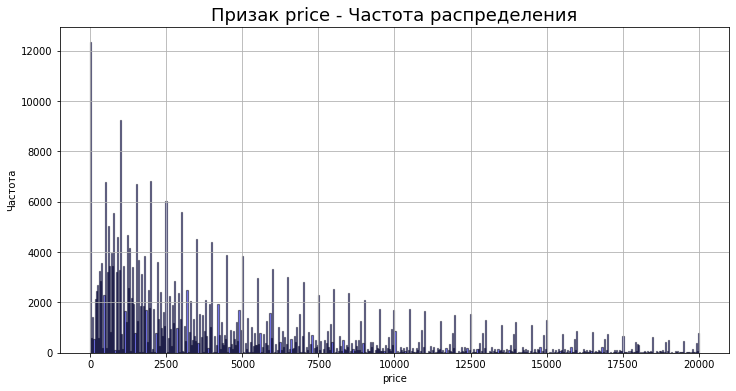

In [18]:
create(df_auto, 'price', 'hist', bins = 550)

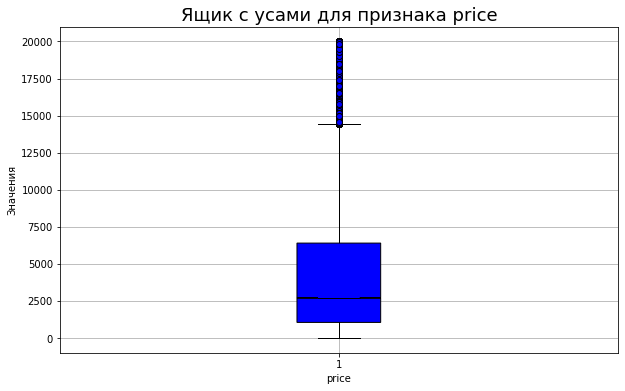

In [19]:
create(df_auto, 'price', 'boxplot')

Удалим все значения меньше 300 евро.

In [20]:
df_auto = df_auto.query('price > 300')

**Признак 'registration_year'**

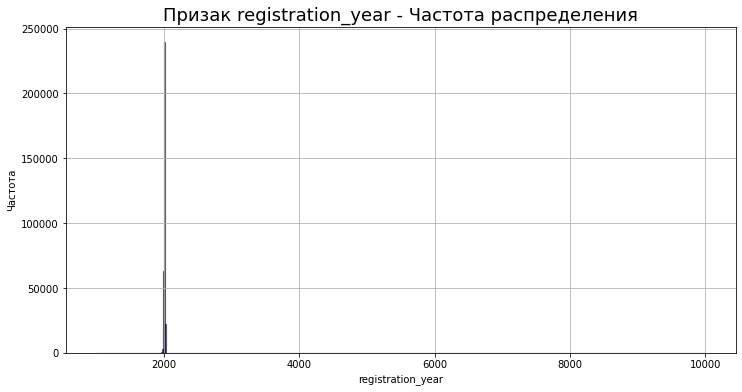

In [21]:
create(df_auto, 'registration_year', 'hist', bins = 550)

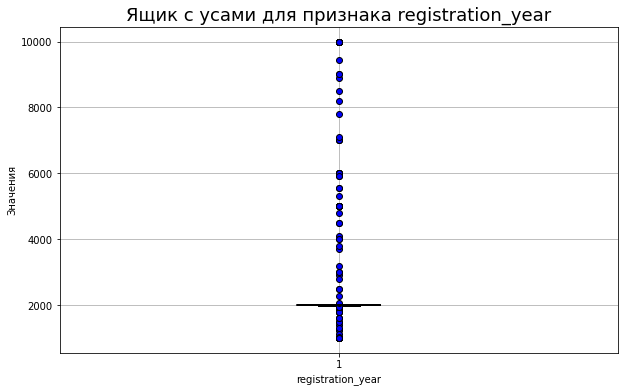

In [22]:
create(df_auto, 'registration_year', 'boxplot')

Так как год регистрации автомобиля не может быть позже последней даты скачивания анкеты из базы, проверим ее.

In [23]:
last_date = pd.to_datetime(df_auto['DateCrawled'])
print(last_date.max())

2016-04-07 14:36:58


In [24]:
df_auto = df_auto.query('registration_year >= 1990 & registration_year < 2017')

In [25]:
df_auto = df_auto.drop('DateCrawled', axis = 1)

**Признак 'power'**

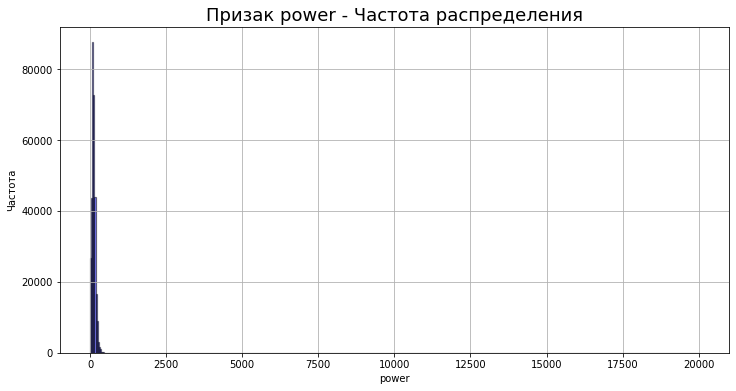

In [26]:
create(df_auto, 'power', 'hist', bins = 550)

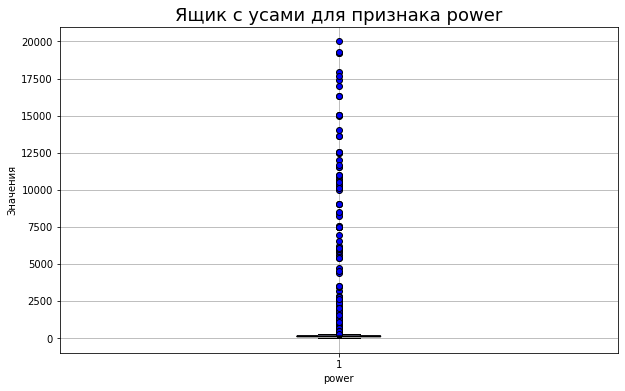

In [27]:
create(df_auto, 'power', 'boxplot')

Оставим данные по машинам с объемами двигателей в диапазоне от 50 до 500 лошадиных сил.

In [28]:
df_auto = df_auto.query('power >= 50 & power <= 500')

**Признак 'kilometer'**

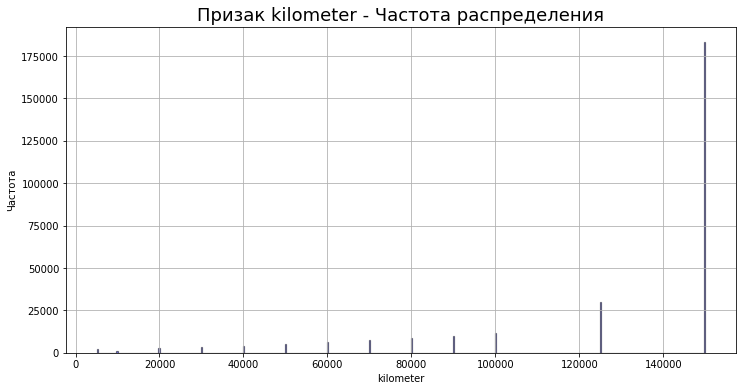

In [29]:
create(df_auto, 'kilometer', 'hist', bins = 550)

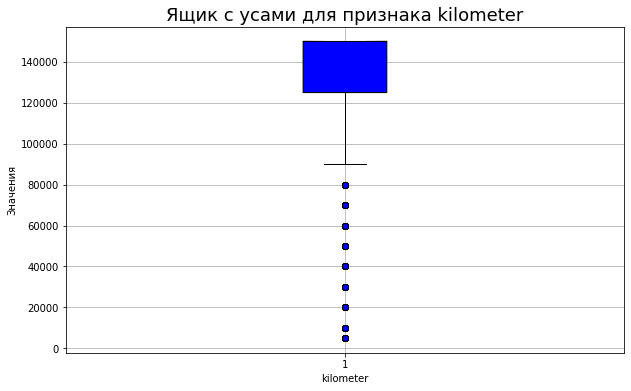

In [30]:
create(df_auto, 'kilometer', 'boxplot')

### Корелляционный анализ

In [31]:
num_cols, cat_cols = cat_num_col(df_auto)

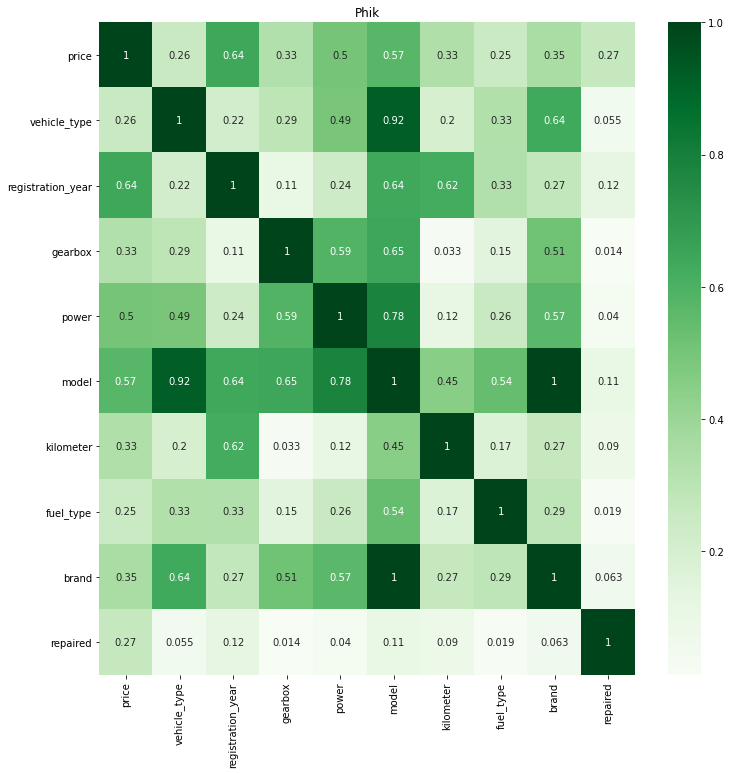

In [32]:
interval_cols = ['price', 'power']
create_phik(df_auto, interval_cols)

**Сильная корелляция наблюдается:**
* Между признаками model и vehicle_type (92%)
* Между признаками model и brand (100%)

**Средняя корелляция наблюдается:**
* Между признаками model и power (78%)
* Между признаками registration_year и price (68%)
* Между признками vehicle_type и brand (64%)

Во остальных случаях наблюдается слабая корелляция или корелляции между признаками не наблюдается вообще

### Подготовка признаков

Разделим данные на признаки, целевой признак.

In [33]:
features = df_auto.drop('price', axis=1)
target = df_auto['price']

Теперь на выборки.

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

Из features отдельно создадим две переменные, хранящие количественные и категориальные признаки.

In [35]:
num_col, cat_col = cat_num_col(features)

Теперь выполним кодировку признаков.

In [36]:
ohe_pipe_tree = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_pipe_linear = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
])

numeric_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [37]:
preprocessor_linear = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe_linear, cat_col),
    ('num', numeric_pipe, num_col)
], remainder='passthrough')

preprocessor_tree_based = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe_tree, cat_col),
    ('num', numeric_pipe, num_col)
], remainder='passthrough')

## Обучение моделей

### Модель LightGBM

In [38]:
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor_tree_based),
    ("lgbm", LGBMRegressor(random_state=RANDOM_STATE))
])

In [39]:
param_grid_lgbm = {
    'lgbm__num_leaves': [31, 50, 70],
    'lgbm__max_depth': [3, 5, 7],
}
best_params_lgbm, execution_time_lgbm, rmse_lgbm, model_lgbm, prediction_time_lgbm, retrain_duration_lgbm = \
optimize_model_with_grid_search(pipeline_lgbm, param_grid_lgbm, features_train, target_train)

### Модель LinearRegression

In [40]:
pipeline_linear = Pipeline([
    ('preprocessor', preprocessor_linear),
    ("linear_regression", LinearRegression(fit_intercept=True))
])

param_grid_linear = {}

In [41]:
best_params_linear, execution_time_linear, rmse_linear, model_linear, prediction_time_linear, retrain_duration_linear = \
optimize_model_with_grid_search(pipeline_linear, param_grid_linear, features_train, target_train)

### Модель CatBoostRegressor

In [42]:
pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor_tree_based),
    ("catboost", CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE'))
])

In [43]:
param_grid_catboost = {
    'catboost__iterations': [10, 30, 50],
}

best_params_catboost, execution_time_catboost, rmse_catboost, model_catboost, prediction_time_catboost, retrain_duration_catboost = \
optimize_model_with_grid_search(pipeline_catboost, param_grid_catboost, features_train, target_train)

Learning rate set to 0.5
0:	learn: 3245.1512175	total: 75.1ms	remaining: 676ms
1:	learn: 2581.4972524	total: 103ms	remaining: 410ms
2:	learn: 2292.1769482	total: 123ms	remaining: 288ms
3:	learn: 2135.0723143	total: 144ms	remaining: 216ms
4:	learn: 2061.7718579	total: 167ms	remaining: 167ms
5:	learn: 2009.5234215	total: 193ms	remaining: 129ms
6:	learn: 1958.3545073	total: 217ms	remaining: 93.1ms
7:	learn: 1931.6462281	total: 238ms	remaining: 59.5ms
8:	learn: 1897.6292697	total: 258ms	remaining: 28.7ms
9:	learn: 1877.8651854	total: 285ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3248.9804406	total: 21.8ms	remaining: 196ms
1:	learn: 2571.4665404	total: 48ms	remaining: 192ms
2:	learn: 2281.3069365	total: 72.3ms	remaining: 169ms
3:	learn: 2138.6962090	total: 92.9ms	remaining: 139ms
4:	learn: 2061.2755002	total: 113ms	remaining: 113ms
5:	learn: 2015.6630263	total: 134ms	remaining: 89.2ms
6:	learn: 1981.5653395	total: 162ms	remaining: 69.3ms
7:	learn: 1931.4077439	total: 184ms	remaini

## Анализ моделей

**Создадим общий список моделей с их параметрами, временем и значением метрики rmse.**

In [44]:
results = {
    "Model": ["LightGBM", "LinearRegression", "CatBoost"],
    "Best Params": [
        best_params_lgbm,
        best_params_linear,
        best_params_catboost
    ],
    "Execution Time (s)": [
        execution_time_lgbm,
        execution_time_linear,
        execution_time_catboost
    ],
    "RMSE": [
        rmse_lgbm,
        rmse_linear,
        rmse_catboost
    ],
    "Prediction Time (s)": [
        prediction_time_lgbm,
        prediction_time_linear,
        prediction_time_catboost
    ],
    "Retrain_duration_time (s)": [
        retrain_duration_lgbm,
        retrain_duration_linear,
        retrain_duration_catboost
    ]
}

results_df = pd.DataFrame(results)

display(results_df)

,Model,Best Params,Execution Time (s),RMSE,Prediction Time (s),Retrain_duration_time (s)
0,LightGBM,"{'lgbm__num_leaves': 70, 'lgbm__max_depth': 7}",269.139277,1578.007232,2.200374,9.001077
1,LinearRegression,{},173.485562,2371.288946,0.639755,23.605963
2,CatBoost,{'catboost__iterations': 50},39.631221,1655.160309,0.963522,3.073948


**Исходя из этих данных:**

* *LinearRegression* показывает наихудшее качество предсказаний (наибольшее RMSE), но обучается быстрее всех и имеет самое короткое время предсказания.
* *LightGBM* имеет лучшее качество предсказаний (наименьшее RMSE), но время обучения у неё самое долгое, хотя время предсказания довольно короткое.
* *CatBoost* занимает среднее положение по качеству предсказаний и времени обучения между LightGBM и Random Forest, и у неё среднее время предсказания.


Если для заказчика первостепенное значение имеет качество предсказания, то LightGBM будет лучшим выбором, несмотря на долгое время обучения. Если важно время обучения и предсказания, но можно пожертвовать некоторым качеством предсказания, то CatBoost может быть оптимальным выбором, так как он обеспечивает баланс между временем и качеством. Random Forest может быть выбран, если важны скорость обучения и предсказания, а качество предсказаний менее критично.

Проверим модель на выборке test

In [45]:
pipeline_catboost.fit(features_train, target_train)

predictions_test = pipeline_catboost.predict(features_test)

rmse_test = np.sqrt(mean_squared_error(target_test, predictions_test))

print(f"RMSE на тестовом наборе данных: {rmse_test}")

Learning rate set to 0.095109
0:	learn: 4315.3120928	total: 26.2ms	remaining: 26.2s
1:	learn: 4050.9057822	total: 53.4ms	remaining: 26.6s
2:	learn: 3818.8877626	total: 80.3ms	remaining: 26.7s
3:	learn: 3610.9736793	total: 109ms	remaining: 27s
4:	learn: 3423.9389784	total: 134ms	remaining: 26.7s
5:	learn: 3258.4606839	total: 160ms	remaining: 26.6s
6:	learn: 3108.9760712	total: 193ms	remaining: 27.4s
7:	learn: 2982.3795279	total: 221ms	remaining: 27.4s
8:	learn: 2867.1117767	total: 250ms	remaining: 27.6s
9:	learn: 2772.1414508	total: 284ms	remaining: 28.2s
10:	learn: 2679.7762008	total: 325ms	remaining: 29.2s
11:	learn: 2599.2787310	total: 355ms	remaining: 29.2s
12:	learn: 2531.3734334	total: 386ms	remaining: 29.3s
13:	learn: 2468.7629009	total: 412ms	remaining: 29s
14:	learn: 2415.8118138	total: 439ms	remaining: 28.8s
15:	learn: 2369.2203347	total: 466ms	remaining: 28.6s
16:	learn: 2324.7737961	total: 497ms	remaining: 28.7s
17:	learn: 2283.1904247	total: 523ms	remaining: 28.5s
18:	learn

## Общий вывод


Итак, обобщая информацию о проекте и различных моделях:

1. LinearRegression показывает худшее качество предсказаний с самым высоким значением RMSE, но обладает преимуществами в виде самого быстрого времени обучения и предсказания. Эта модель подходит, если важны скорость работы и меньшие затраты на вычислительные ресурсы, но можно пожертвовать точностью.
2. LightGBM предлагает лучшее качество предсказаний с наименьшим RMSE, но требует значительно больше времени на обучение. Однако, время предсказания у модели остается на удовлетворительном уровне. Этот вариант идеален, если приоритетным является качество предсказаний, а время обучения не критично.
3. CatBoost находится на среднем уровне как по качеству предсказаний, так и по времени обучения и предсказания между LightGBM и LinearRegression. С RMSE на тестовом наборе в 1516.89, CatBoost представляет собой хороший компромисс между скоростью и точностью.

**Выбор модели зависит от приоритетов заказчика:**
* Если важнейшим является качество предсказания, то стоит выбрать LightGBM.
* Если же требуется сбалансированное решение с приемлемым временем обучения и качеством, то CatBoost будет оптимальным выбором.
* LinearRegression можно рассматривать, когда необходима максимальная скорость обучения и предсказания за счет снижения точности.